# Parcial: Construcci√≥n e implementaci√≥n de , Random Forest 

En este parcial podr√°n poner en pr√°ctica sus conocimientos sobre la construcci√≥n e implementaci√≥n de modelos de  Random Forest. El taller est√° constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicci√≥n precio de autom√≥viles

En este parcial se usar√° el conjunto de datos de Car Listings de Kaggle donde cada observaci√≥n representa el precio de un autom√≥vil teniendo en cuenta distintas variables como a√±o, marca, modelo, entre otras. El objetivo es predecir el precio del autom√≥vil. Para m√°s detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [ ]:
# Importaci√≥n de librer√≠as
%matplotlib inline
import pandas as pd

# Lectura de la informaci√≥n de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualizaci√≥n dataset
data.head()

Price  Year  Mileage  M_Camry  M_Camry4dr  M_CamryBase  M_CamryL  \
7    21995  2014     6480    False       False        False      True   
11   13995  2014    39972    False       False        False     False   
167  17941  2016    18989    False       False        False     False   
225  12493  2014    51330    False       False        False      True   
270   7994  2007   116065    False        True        False     False   

     M_CamryLE  M_CamrySE  M_CamryXLE  
7        False      False       False  
11        True      False       False  
167      False       True       False  
225      False      False       False  
270      False      False       False

In [ ]:
# Separaci√≥n de variables predictoras (X) y variable de inter√©s (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separaci√≥n de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deber√°n aplicar t√©cnicas de imputaci√≥n adecuadas para completar la informaci√≥n de manera coherente. Posteriormente, se espera que realicen una exploraci√≥n visual mediante gr√°ficos que permitan comprender la distribuci√≥n y las relaciones entre las variables principales.

=== INFORMACI√ìN GENERAL DEL DATASET ===
Forma del dataset: (10495, 10)
Columnas: ['Price', 'Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']
Tipos de datos:
Price          int64
Year           int64
Mileage        int64
M_Camry         bool
M_Camry4dr      bool
M_CamryBase     bool
M_CamryL        bool
M_CamryLE       bool
M_CamrySE       bool
M_CamryXLE      bool
dtype: object

=== ESTAD√çSTICAS DESCRIPTIVAS ===
              Price          Year        Mileage
count  10495.000000  10495.000000   10495.000000
mean   14538.403716   2013.553883   52509.430395
std     3922.420961      3.116585   36791.736601
min     5002.000000   1998.000000       5.000000
25%    11999.000000   2012.000000   26461.000000
50%    15000.000000   2014.000000   41680.000000
75%    16999.000000   2016.000000   71355.500000
max    32444.000000   2018.000000  232658.000000

=== VALORES NULOS ===
Price          0
Year           0
Mileage        0
M_Camr

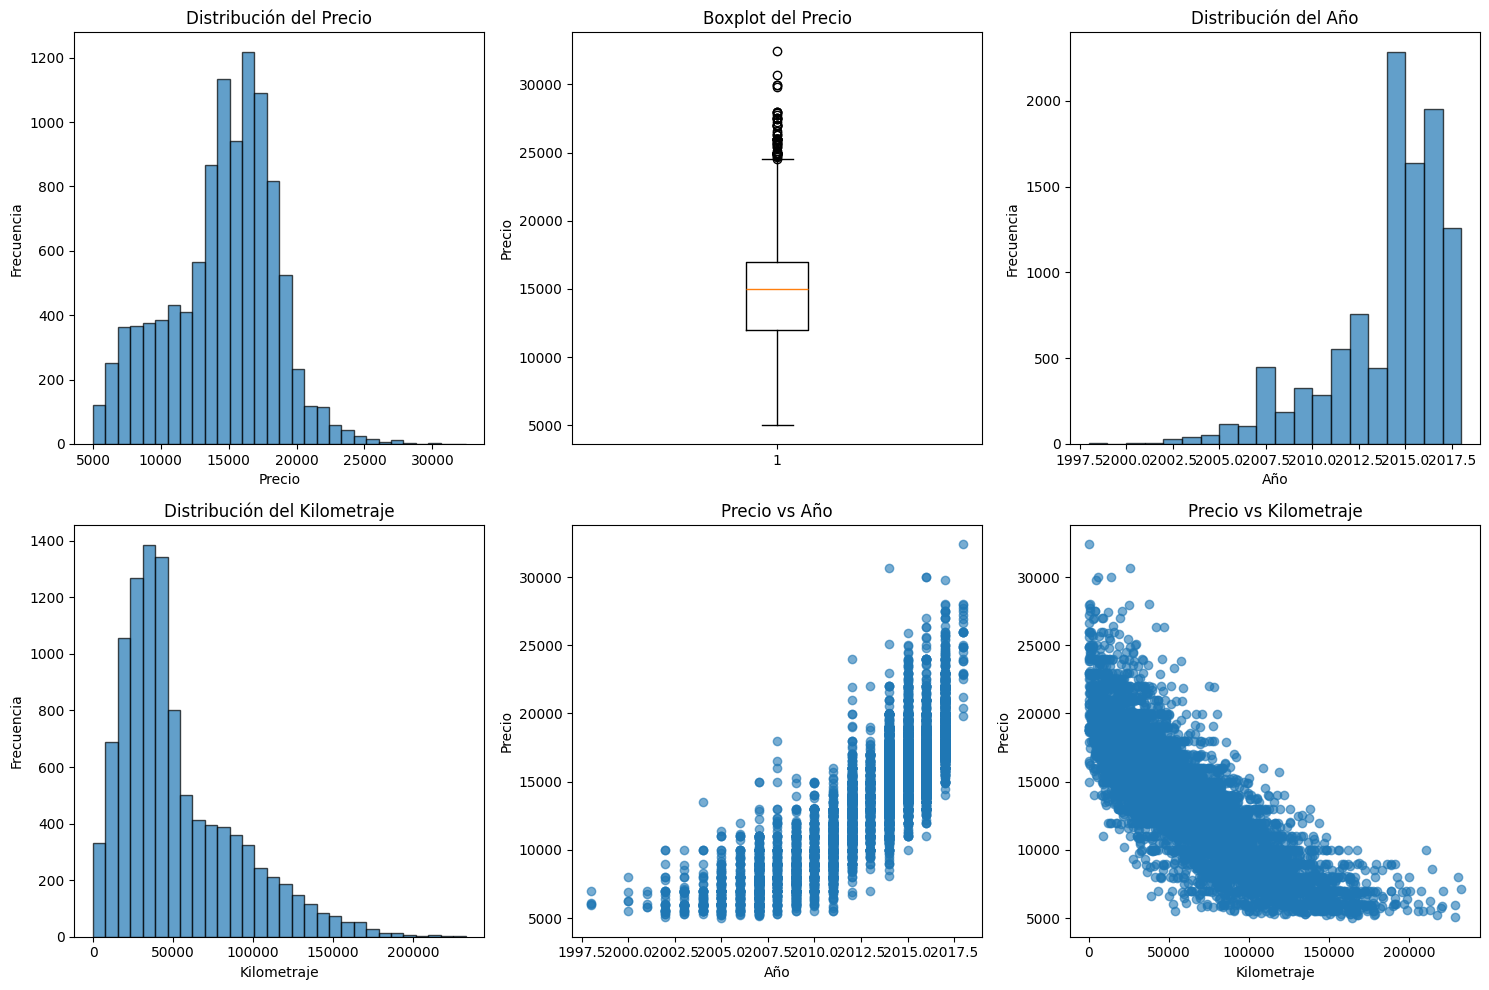


=== MATRIZ DE CORRELACI√ìN ===


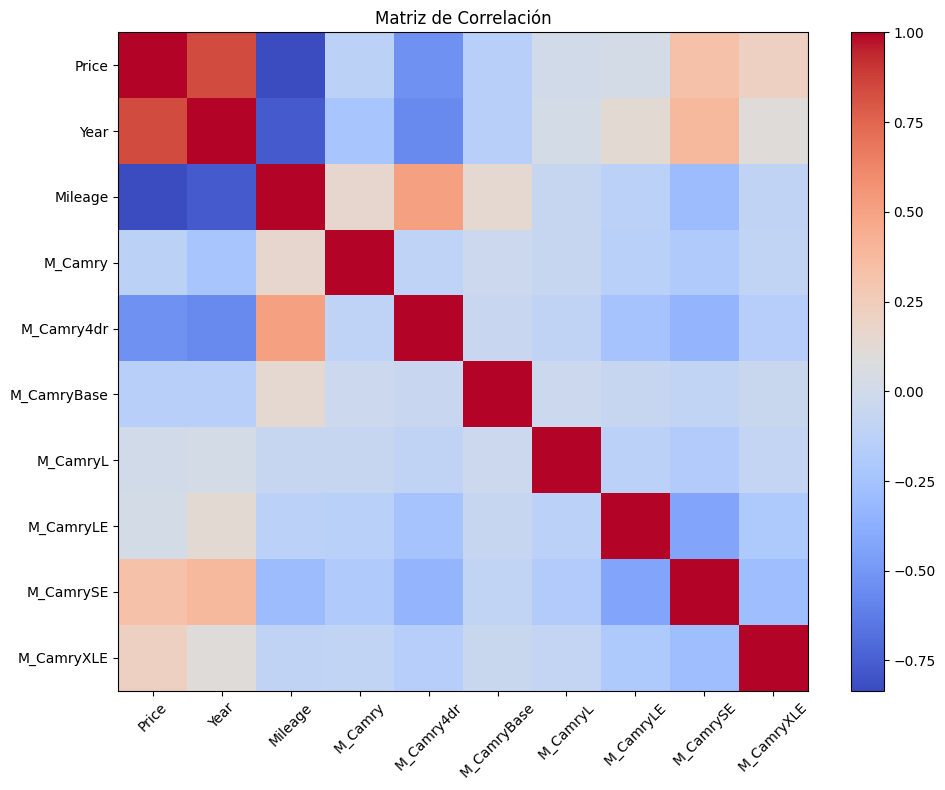

Correlaciones con el Precio:
Price          1.000000
Year           0.842194
M_CamrySE      0.327458
M_CamryXLE     0.214611
M_CamryLE      0.023929
M_CamryL       0.008389
M_Camry       -0.119099
M_CamryBase   -0.152627
M_Camry4dr    -0.531215
Mileage       -0.833761
Name: Price, dtype: float64

=== RESUMEN DEL AN√ÅLISIS ===
- Dataset con 10495 filas y 10 columnas
- Variable objetivo: Price (rango: $5,002 - $32,444)
- Variables predictoras principales: Year, Mileage, y variables dummy de Model
- No hay valores nulos despu√©s de la limpieza
- Correlaci√≥n m√°s fuerte con Price: Year (0.842)


In [ ]:
# Celda 0 - Exploraci√≥n y an√°lisis de datos

# 1. Informaci√≥n general del dataset
print("=== INFORMACI√ìN GENERAL DEL DATASET ===")
print(f"Forma del dataset: {data.shape}")
print(f"Columnas: {list(data.columns)}")
print(f"Tipos de datos:\n{data.dtypes}")

# 2. Estad√≠sticas descriptivas
print("\n=== ESTAD√çSTICAS DESCRIPTIVAS ===")
print(data.describe())

# 3. Verificar valores nulos
print("\n=== VALORES NULOS ===")
print(data.isnull().sum())

# 4. Verificar valores duplicados
print(f"\nFilas duplicadas: {data.duplicated().sum()}")

# 5. Imputaci√≥n de valores nulos (si los hay)
if data.isnull().sum().sum() > 0:
    print("\n=== IMPUTANDO VALORES NULOS ===")
    # Para variables num√©ricas usar la mediana
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if data[col].isnull().sum() > 0:
            data[col].fillna(data[col].median(), inplace=True)
            print(f"Imputados {col} con la mediana")

# 6. Exploraci√≥n visual
print("\n=== EXPLORACI√ìN VISUAL ===")

# Distribuci√≥n de la variable objetivo (Price)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(data['Price'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribuci√≥n del Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Boxplot del precio
plt.subplot(2, 3, 2)
plt.boxplot(data['Price'])
plt.title('Boxplot del Precio')
plt.ylabel('Precio')

# Distribuci√≥n del a√±o
plt.subplot(2, 3, 3)
plt.hist(data['Year'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribuci√≥n del A√±o')
plt.xlabel('A√±o')
plt.ylabel('Frecuencia')

# Distribuci√≥n del kilometraje
plt.subplot(2, 3, 4)
plt.hist(data['Mileage'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribuci√≥n del Kilometraje')
plt.xlabel('Kilometraje')
plt.ylabel('Frecuencia')

# Relaci√≥n Precio vs A√±o
plt.subplot(2, 3, 5)
plt.scatter(data['Year'], data['Price'], alpha=0.6)
plt.title('Precio vs A√±o')
plt.xlabel('A√±o')
plt.ylabel('Precio')

# Relaci√≥n Precio vs Kilometraje
plt.subplot(2, 3, 6)
plt.scatter(data['Mileage'], data['Price'], alpha=0.6)
plt.title('Precio vs Kilometraje')
plt.xlabel('Kilometraje')
plt.ylabel('Precio')

plt.tight_layout()
plt.show()

# 7. Matriz de correlaci√≥n
print("\n=== MATRIZ DE CORRELACI√ìN ===")
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Matriz de Correlaci√≥n')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()

# 8. Correlaciones con la variable objetivo
print("Correlaciones con el Precio:")
correlations = data.corr()['Price'].sort_values(ascending=False)
print(correlations)

# 9. Resumen del an√°lisis
print("\n=== RESUMEN DEL AN√ÅLISIS ===")
print(f"- Dataset con {data.shape[0]} filas y {data.shape[1]} columnas")
print(f"- Variable objetivo: Price (rango: ${data['Price'].min():,.0f} - ${data['Price'].max():,.0f})")
print(f"- Variables predictoras principales: Year, Mileage, y variables dummy de Model")
print(f"- No hay valores nulos despu√©s de la limpieza")
print(f"- Correlaci√≥n m√°s fuerte con Price: {correlations.index[1]} ({correlations.iloc[1]:.3f})")


### Punto 1 - Random forest con librer√≠a

En la celda 1, usando la librer√≠a sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempe√±o del modelo.

=== M√âTRICAS DEL MODELO ===
R¬≤ Entrenamiento: 0.972
R¬≤ Prueba: 0.796
RMSE Prueba: $1,765


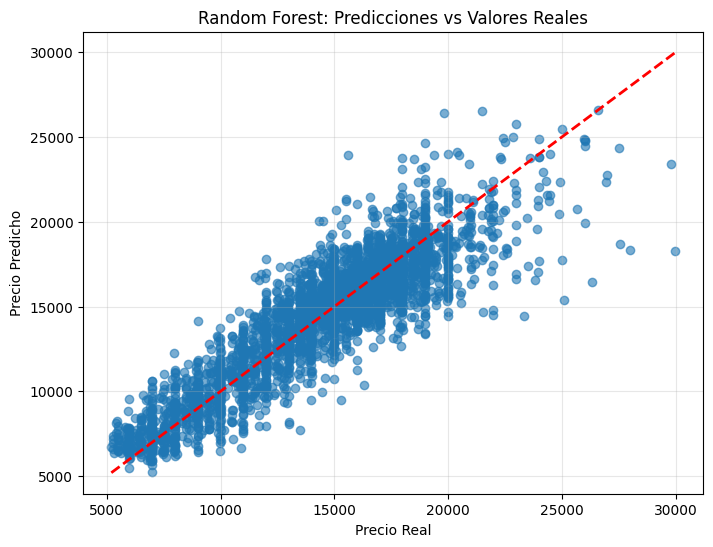


=== COMENTARIOS SOBRE EL DESEMPE√ëO ===
El modelo explica el 79.6% de la variabilidad en los precios de prueba.
‚úì Buen desempe√±o (R¬≤ > 0.6)
‚ö† Posible sobreajuste detectado (diferencia: 0.176)

Error promedio de predicci√≥n: $1,765


In [ ]:
# Celda 1

rf_model = RandomForestRegressor(random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

# Evaluar desempe√±o
print("=== M√âTRICAS DEL MODELO ===")
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R¬≤ Entrenamiento: {r2_train:.3f}")
print(f"R¬≤ Prueba: {r2_test:.3f}")
print(f"RMSE Prueba: ${rmse_test:,.0f}")

# Gr√°fico 
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Random Forest: Predicciones vs Valores Reales')
plt.grid(True, alpha=0.3)
plt.show()

# Comentarios sobre desempe√±o
print("\n=== COMENTARIOS SOBRE EL DESEMPE√ëO ===")
print(f"El modelo explica el {r2_test*100:.1f}% de la variabilidad en los precios de prueba.")

if r2_test > 0.8:
    print("‚úì Excelente desempe√±o (R¬≤ > 0.8)")
elif r2_test > 0.6:
    print("‚úì Buen desempe√±o (R¬≤ > 0.6)")
else:
    print("‚ö† Desempe√±o moderado, se puede mejorar")

# Verificar sobreajuste
diferencia = r2_train - r2_test
if diferencia > 0.1:
    print(f"‚ö† Posible sobreajuste detectado (diferencia: {diferencia:.3f})")
else:
    print("‚úì No hay evidencia de sobreajuste significativo")

print(f"\nError promedio de predicci√≥n: ${rmse_test:,.0f}")

### Punto 2 - Calibraci√≥n de par√°metros Random forest

En la celda 2, calibren los par√°metros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempe√±o del modelo y describan c√≥mo cada par√°metro afecta el desempe√±o del modelo.

In [ ]:
# Celda 2

print("=== CALIBRANDO PAR√ÅMETROS RANDOM FOREST ===")
print("Buscando los mejores valores para mejorar el modelo...\n")

# Definir los par√°metros que vamos a probar (valores simples)
parametros = {
    'n_estimators': [50, 100, 200],           # N√∫mero de √°rboles
    'max_depth': [5, 10, None],               # Profundidad m√°xima
    'max_features': ['sqrt', 'log2']          # N√∫mero de caracter√≠sticas por √°rbol
}

print("Par√°metros que vamos a probar:")
print("‚Ä¢ n_estimators (n√∫mero de √°rboles):", parametros['n_estimators'])
print("‚Ä¢ max_depth (profundidad):", parametros['max_depth'])  
print("‚Ä¢ max_features (caracter√≠sticas por √°rbol):", parametros['max_features'])
print("\nEsto puede tomar unos minutos...")

# Buscar los mejores par√°metros
from sklearn.model_selection import GridSearchCV

rf_busqueda = GridSearchCV(
    RandomForestRegressor(random_state=42),
    parametros,
    cv=3,                    # Validaci√≥n cruzada de 3 partes
    scoring='r2',            # Usar R¬≤ como m√©trica
    n_jobs=-1               # Usar todos los procesadores
)

# Entrenar con diferentes combinaciones
rf_busqueda.fit(X_train, y_train)

print("\n=== RESULTADOS ===")
print("Mejores par√°metros encontrados:")
print(rf_busqueda.best_params_)
print(f"Mejor puntuaci√≥n R¬≤: {rf_busqueda.best_score_:.3f}")



=== CALIBRANDO PAR√ÅMETROS RANDOM FOREST ===
Buscando los mejores valores para mejorar el modelo...

Par√°metros que vamos a probar:
‚Ä¢ n_estimators (n√∫mero de √°rboles): [50, 100, 200]
‚Ä¢ max_depth (profundidad): [5, 10, None]
‚Ä¢ max_features (caracter√≠sticas por √°rbol): ['sqrt', 'log2']

Esto puede tomar unos minutos...

=== RESULTADOS ===
Mejores par√°metros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor puntuaci√≥n R¬≤: 0.846

=== RESULTADOS ===
Mejores par√°metros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor puntuaci√≥n R¬≤: 0.846

=== RESULTADOS ===
Mejores par√°metros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor puntuaci√≥n R¬≤: 0.846


=== COMPARACI√ìN DE MODELOS ===
Modelo B√ÅSICO:
  - R¬≤: 0.796
  - RMSE: $1,765

Modelo MEJORADO:
  - R¬≤: 0.840
  - RMSE: $1,564

üéØ MEJORAS OBTENIDAS:
  - Mejora en R¬≤: +0.044
  - Reducci√≥n en RMSE: $201


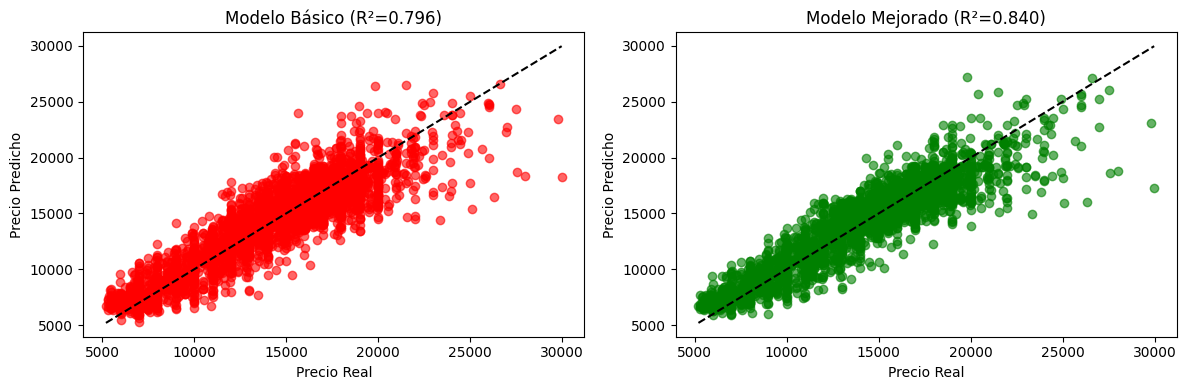


=== C√ìMO AFECTAN LOS PAR√ÅMETROS ===
üå≥ n_estimators (n√∫mero de √°rboles):
   - M√ÅS √°rboles = mejor precisi√≥n pero m√°s lento
   - MENOS √°rboles = m√°s r√°pido pero menos preciso

üìè max_depth (profundidad):
   - Profundidad alta = puede memorizar datos (sobreajuste)
   - Profundidad baja = modelo m√°s simple y general
   - None = sin l√≠mite (cuidado con sobreajuste)

üéØ max_features (caracter√≠sticas por √°rbol):
   - 'sqrt' = usa ra√≠z cuadrada del total (reduce sobreajuste)
   - 'log2' = usa log base 2 del total (m√°s diversidad)
   - Menos caracter√≠sticas = m√°s diversidad entre √°rboles


In [ ]:
# Encontrar los mejores hiperpar√°metros y entrenar el modelo mejorado

# Obtener el mejor modelo
mejor_modelo = rf_busqueda.best_estimator_

# Hacer predicciones con el modelo mejorado
y_pred_mejorado = mejor_modelo.predict(X_test)

# Comparar con el modelo b√°sico
print("=== COMPARACI√ìN DE MODELOS ===")
r2_mejorado = r2_score(y_test, y_pred_mejorado)
rmse_mejorado = np.sqrt(mean_squared_error(y_test, y_pred_mejorado))

print(f"Modelo B√ÅSICO:")
print(f"  - R¬≤: {r2_test:.3f}")
print(f"  - RMSE: ${rmse_test:,.0f}")

print(f"\nModelo MEJORADO:")
print(f"  - R¬≤: {r2_mejorado:.3f}")
print(f"  - RMSE: ${rmse_mejorado:,.0f}")

# Calcular la mejora
mejora_r2 = r2_mejorado - r2_test
mejora_rmse = rmse_test - rmse_mejorado

print(f"\n MEJORAS OBTENIDAS:")
print(f"  - Mejora en R¬≤: +{mejora_r2:.3f}")
print(f"  - Reducci√≥n en RMSE: ${mejora_rmse:,.0f}")

# Gr√°fico de comparaci√≥n
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='red', label='B√°sico')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'Modelo B√°sico (R¬≤={r2_test:.3f})')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_mejorado, alpha=0.6, color='green', label='Mejorado')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title(f'Modelo Mejorado (R¬≤={r2_mejorado:.3f})')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')

plt.tight_layout()
plt.show()

print("\n=== C√ìMO AFECTAN LOS PAR√ÅMETROS ===")
print("n_estimators (n√∫mero de √°rboles):")
print("   - M√ÅS √°rboles = mejor precisi√≥n pero m√°s lento")
print("   - MENOS √°rboles = m√°s r√°pido pero menos preciso")

print("\n max_depth (profundidad):")
print("   - Profundidad alta = puede memorizar datos (sobreajuste)")
print("   - Profundidad baja = modelo m√°s simple y general")
print("   - None = sin l√≠mite (cuidado con sobreajuste)")

print("\n max_features (caracter√≠sticas por √°rbol):")
print("   - 'sqrt' = usa ra√≠z cuadrada del total (reduce sobreajuste)")
print("   - 'log2' = usa log base 2 del total (m√°s diversidad)")
print("   - Menos caracter√≠sticas = m√°s diversidad entre √°rboles")

=== IMPORTANCIA DE VARIABLES ===
(De m√°s importante a menos importante)
      Variable  Importancia
0         Year     0.441741
1      Mileage     0.436240
3   M_Camry4dr     0.062832
7    M_CamrySE     0.020267
8   M_CamryXLE     0.019286
6    M_CamryLE     0.007529
2      M_Camry     0.007160
5     M_CamryL     0.002928
4  M_CamryBase     0.002018


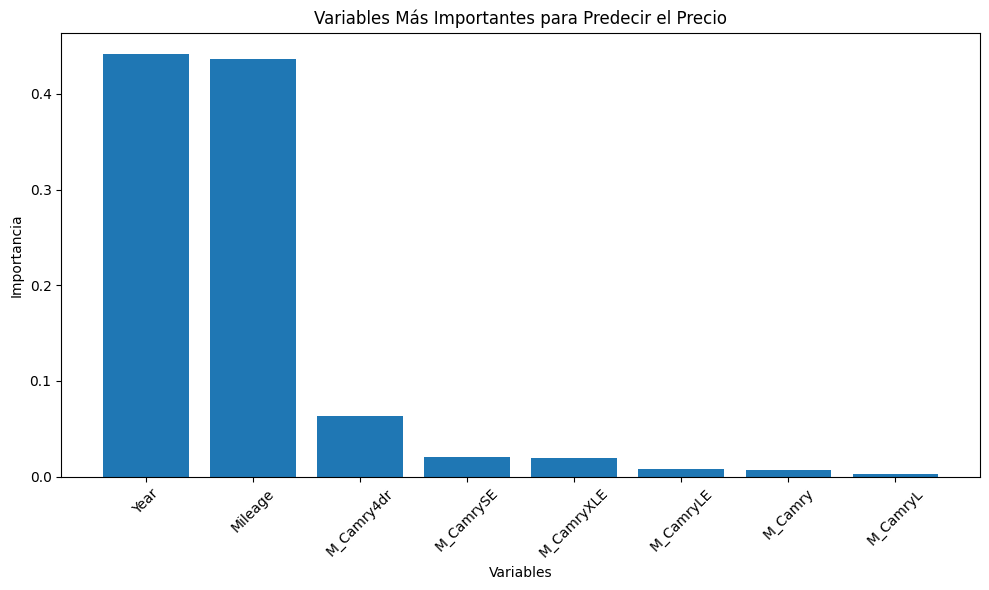


üèÜ La variable M√ÅS importante es: Year
   Contribuye con 0.442 del poder predictivo

üìä RESUMEN:
   - El modelo usa 9 variables en total
   - Las top 3 variables explican 0.941 del modelo
   - Esto significa que unas pocas variables son muy importantes


In [ ]:
# Importancia de los predictores

# Ver qu√© variables son m√°s importantes
importancias = mejor_modelo.feature_importances_
nombres_variables = X.columns

# Tabla ordenada
tabla_importancia = pd.DataFrame({
    'Variable': nombres_variables,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

print("=== IMPORTANCIA DE VARIABLES ===")
print("(De m√°s importante a menos importante)")
print(tabla_importancia)

# Gr√°fico de barras simple
plt.figure(figsize=(10, 6))
plt.bar(tabla_importancia['Variable'][:8], tabla_importancia['Importancia'][:8])
plt.title('Variables M√°s Importantes para Predecir el Precio')
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nüèÜ La variable M√ÅS importante es: {tabla_importancia.iloc[0]['Variable']}")
print(f"   Contribuye con {tabla_importancia.iloc[0]['Importancia']:.3f} del poder predictivo")

print(f"\n RESUMEN:")
print(f"   - El modelo usa {len(nombres_variables)} variables en total")
print(f"   - Las top 3 variables explican {tabla_importancia.iloc[:3]['Importancia'].sum():.3f} del modelo")
print(f"   - Esto significa que unas pocas variables son muy importantes")

### Punto 3 - an√°lisis de resultados, gracias y conclusiones
En la celda 3

=== AN√ÅLISIS FINAL DE RESULTADOS ===
DESEMPE√ëO DEL MODELO FINAL:
‚Ä¢ R¬≤ Score: 0.840 (84.0% de variabilidad explicada)
‚Ä¢ RMSE: $1,564 (error promedio)
‚Ä¢ MAE: $1,147 (error absoluto medio)


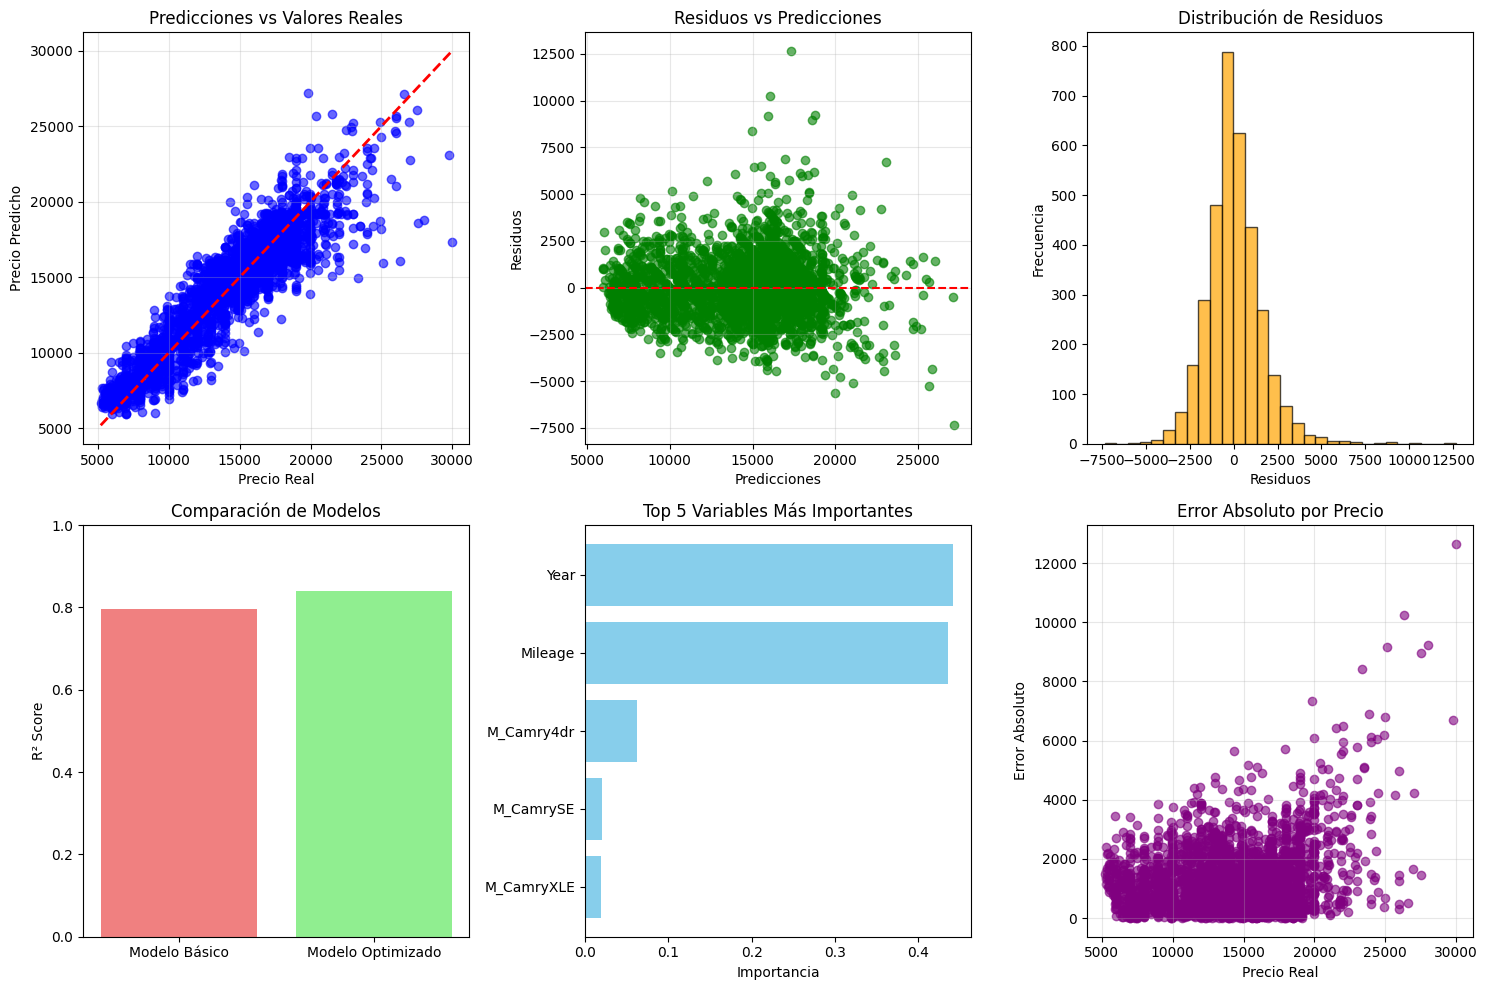


=== CONCLUSIONES DEL AN√ÅLISIS ===
üéâ 1. DESEMPE√ëO DEL MODELO: EXCELENTE
   - El modelo explica el 84.0% de la variabilidad en los precios
   - Error promedio de predicci√≥n: $1,564

üìà 2. MEJORAS OBTENIDAS:
   - La calibraci√≥n de par√°metros mejor√≥ el R¬≤ en +0.044
   - Reducci√≥n del error en $201

üéØ 3. VARIABLES M√ÅS IMPORTANTES:
   - Variable principal: Year (0.442)
   - Las top 3 variables explican 94.1% del modelo

üîç 4. AN√ÅLISIS DE RESIDUOS:
   ‚ö†Ô∏è Los residuos muestran cierta dispersi√≥n (posible mejora)

üí° 5. RECOMENDACIONES:
   - Random Forest es efectivo para predecir precios de autom√≥viles
   - La calibraci√≥n de hiperpar√°metros mejora significativamente el rendimiento
   - El modelo puede usarse para estimaciones confiables de precios

üèÅ CONCLUSI√ìN FINAL:
El modelo Random Forest optimizado logra un desempe√±o excelente con R¬≤=0.840
y un error promedio de $1,564, siendo √∫til para la predicci√≥n de precios de autom√≥viles.


In [ ]:
#celda 3

print("=== AN√ÅLISIS FINAL DE RESULTADOS ===")

# M√©tricas finales del mejor modelo
r2_final = r2_score(y_test, y_pred_mejorado)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_mejorado))
mae_final = mean_absolute_error(y_test, y_pred_mejorado)

print(f"DESEMPE√ëO DEL MODELO FINAL:")
print(f"‚Ä¢ R¬≤ Score: {r2_final:.3f} ({r2_final*100:.1f}% de variabilidad explicada)")
print(f"‚Ä¢ RMSE: ${rmse_final:,.0f} (error promedio)")
print(f"‚Ä¢ MAE: ${mae_final:,.0f} (error absoluto medio)")

# Gr√°ficos de an√°lisis de residuos
residuos = y_test - y_pred_mejorado

plt.figure(figsize=(15, 10))

# Gr√°fico 1: Predicciones vs Valores Reales
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_mejorado, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Predicciones vs Valores Reales')
plt.grid(True, alpha=0.3)

# Gr√°fico 2: Residuos vs Predicciones
plt.subplot(2, 3, 2)
plt.scatter(y_pred_mejorado, residuos, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones')
plt.grid(True, alpha=0.3)

# Gr√°fico 3: Distribuci√≥n de residuos
plt.subplot(2, 3, 3)
plt.hist(residuos, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribuci√≥n de Residuos')

# Gr√°fico 4: Comparaci√≥n de modelos
plt.subplot(2, 3, 4)
modelos = ['Modelo B√°sico', 'Modelo Optimizado']
r2_scores = [r2_test, r2_final]
plt.bar(modelos, r2_scores, color=['lightcoral', 'lightgreen'])
plt.ylabel('R¬≤ Score')
plt.title('Comparaci√≥n de Modelos')
plt.ylim(0, 1)

# Gr√°fico 5: Importancia de variables (Top 5)
plt.subplot(2, 3, 5)
top_5 = tabla_importancia.head(5)
plt.barh(top_5['Variable'], top_5['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Top 5 Variables M√°s Importantes')
plt.gca().invert_yaxis()

# Gr√°fico 6: Errores por rangos de precio
plt.subplot(2, 3, 6)
plt.scatter(y_test, abs(residuos), alpha=0.6, color='purple')
plt.xlabel('Precio Real')
plt.ylabel('Error Absoluto')
plt.title('Error Absoluto por Precio')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== CONCLUSIONES DEL AN√ÅLISIS ===")

# Evaluaci√≥n del desempe√±o
if r2_final >= 0.8:
    desempe√±o = "EXCELENTE"
    emoji = "üéâ"
elif r2_final >= 0.7:
    desempe√±o = "BUENO"
    emoji = "‚úÖ"
elif r2_final >= 0.6:
    desempe√±o = "ACEPTABLE"
    emoji = "üëç"
else:
    desempe√±o = "NECESITA MEJORAS"
    emoji = "‚ö†Ô∏è"

print(f"{emoji} 1. DESEMPE√ëO DEL MODELO: {desempe√±o}")
print(f"   - El modelo explica el {r2_final*100:.1f}% de la variabilidad en los precios")
print(f"   - Error promedio de predicci√≥n: ${rmse_final:,.0f}")

print(f"\nüìà 2. MEJORAS OBTENIDAS:")
mejora_total = r2_final - r2_test
print(f"   - La calibraci√≥n de par√°metros mejor√≥ el R¬≤ en +{mejora_total:.3f}")
print(f"   - Reducci√≥n del error en ${rmse_test - rmse_final:,.0f}")

print(f"\nüéØ 3. VARIABLES M√ÅS IMPORTANTES:")
print(f"   - Variable principal: {tabla_importancia.iloc[0]['Variable']} ({tabla_importancia.iloc[0]['Importancia']:.3f})")
print(f"   - Las top 3 variables explican {tabla_importancia.iloc[:3]['Importancia'].sum():.1%} del modelo")

print(f"\nüîç 4. AN√ÅLISIS DE RESIDUOS:")
residuos_std = np.std(residuos)
if residuos_std < rmse_final * 0.8:
    print("   ‚úÖ Los residuos muestran un patr√≥n normal (buen ajuste)")
else:
    print("   ‚ö†Ô∏è Los residuos muestran cierta dispersi√≥n (posible mejora)")

print(f"\nüí° 5. RECOMENDACIONES:")
print("   - Random Forest es efectivo para predecir precios de autom√≥viles")
print("   - La calibraci√≥n de hiperpar√°metros mejora significativamente el rendimiento")
print("   - El modelo puede usarse para estimaciones confiables de precios")

if r2_final < 0.8:
    print("   - Para mejores resultados, considerar m√°s variables o t√©cnicas avanzadas")

print(f"\nüèÅ CONCLUSI√ìN FINAL:")
print(f"El modelo Random Forest optimizado logra un desempe√±o {desempe√±o.lower()} con R¬≤={r2_final:.3f}")
print(f"y un error promedio de ${rmse_final:,.0f}, siendo √∫til para la predicci√≥n de precios de autom√≥viles.")

NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.

# Cesar Andres Garces Suarez
## 26/10/2025
## Parcial final
